<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ThreeBodyTB_julia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Example of how to run [`ThreeBodyTB`](https://github.com/usnistgov/ThreeBodyTB.jl) using julia.

First we have to:

 1) install julia,

 2) reload the page, and

 3) then install `ThreeBodyTB`, which takes a while. Once things are installed, commands work reasonably quickly the second time they are run, as the machine code is cached.**

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook for ThreeBodyTB_

## Reference: https://doi.org/10.1103/PhysRevMaterials.7.044603

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.9.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.9.2
Commit e4ee485e909 (2023-07-05 09:39 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, broadwell)
  Threads: 3 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


#ThreeBodyTB

**Load the ThreeBodyTB code. Unfortunately this takes a while the first time, as many other packages must be downloaded for our fresh installation.**

In [2]:
using Pkg
Pkg.add(url = "https://github.com/usnistgov/ThreeBodyTB.jl", rev = "develop3")
using ThreeBodyTB
Pkg.add("Plots")
using Plots

     Cloning git-repo `https://github.com/usnistgov/ThreeBodyTB.jl`
    Updating git-repo `https://github.com/usnistgov/ThreeBodyTB.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed JpegTurbo_jll ──────────────────── v2.1.91+0
   Installed LERC_jll ───────────────────────── v3.0.0+1
   Installed x265_jll ───────────────────────── v3.5.0+0
   Installed libfdk_aac_jll ─────────────────── v2.0.2+0
   Installed Libmount_jll ───────────────────── v2.35.0+0
   Installed GR_jll ─────────────────────────── v0.72.10+0
   Installed FFTW ───────────────────────────── v1.7.1
   Installed OffsetArrays ───────────────────── v1.12.10
   Installed Opus_jll ───────────────────────── v1.3.2+0
   Installed LoggingExtras ──────────────────── v1.0.3
   Installed Xorg_xkbcomp_jll ───────────────── v1.4.6+0
   Installed RelocatableFolders ─────────────── v1.0.1
   Installed Unitful ────────────────────────── v1.17.0
   Installed Measures ───────────

**Define an AlP primitive unit cell (zincblende structure).**

In [3]:
A = [0 2.73 2.73; 2.73 0 2.73; 2.73 2.73 0] #angstrom lattice vectors
pos = [0 0 0; 0.25 0.25 0.25]               #crystal coordinates
atoms = ["Al", "P"]                         #strings or symbols are fine
c = makecrys(A, pos, atoms)

Units: Å

A1=     0.00000  2.73000  2.73000
A2=     2.73000  0.00000  2.73000
A3=     2.73000  2.73000  0.00000

Al   0.00000  0.00000  0.00000
P    0.25000  0.25000  0.25000


**Create a 2x2x2 supercell, use the simple plotter for fun.**

s P blue
s Al orange


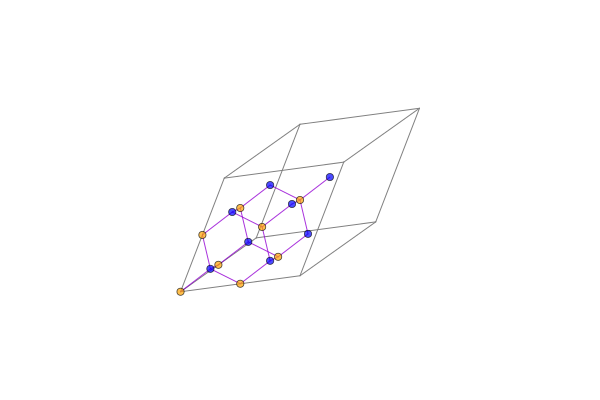

In [4]:
c222 = c * [2,2,2]
plot(c222)

**Calculate energy of AlP**

In [6]:
energy, tbc, flag = scf_energy(c);


found /root/.julia/packages/ThreeBodyTB/4nbDG/src/../dats/pbesol/v1.3/els/coef.el.2bdy.P.xml.gz
Tuple{Symbol, Symbol}
found /root/.julia/packages/ThreeBodyTB/4nbDG/src/../dats/pbesol/v1.3/els/coef.el.3bdy.P.xml.gz
found /root/.julia/packages/ThreeBodyTB/4nbDG/src/../dats/pbesol/v1.3/binary/coef.el.2bdy.Al.P.xml.gz
Tuple{Symbol, Symbol}
Tuple{Symbol, Symbol}
found /root/.julia/packages/ThreeBodyTB/4nbDG/src/../dats/pbesol/v1.3/binary/coef.el.3bdy.Al.P.xml.gz
found /root/.julia/packages/ThreeBodyTB/4nbDG/src/../dats/pbesol/v1.3/els/coef.el.2bdy.Al.xml.gz
Tuple{Symbol, Symbol}
found /root/.julia/packages/ThreeBodyTB/4nbDG/src/../dats/pbesol/v1.3/els/coef.el.3bdy.Al.xml.gz

calc tb

START SCF ----------------
SCF CALC 0001 energy  -10.85101555    
SCF CALC 0002 energy  -10.85062555  en_diff:   3.899945E-04  dq_diff:   1.780704E+00   mix: 1.000000E+00 
SCF CALC 0003 energy  -10.84981428  en_diff:   8.112721E-04  dq_diff:   1.700514E+00   mix: 1.000000E+00 
SCF CALC 0004 energy  -10.7284055

**The `tbc` object contains information on the SCF Hamiltonian, band structure, etc, for plotting purposes, etc.**

In [7]:
tbc


tb_crys object 

Units: Å

A1=     0.00000  2.73000  2.73000
A2=     2.73000  0.00000  2.73000
A3=     2.73000  2.73000  0.00000

Al   0.00000  0.00000  0.00000
P    0.25000  0.25000  0.25000


nelec: 8.0; nspin (hoppings): 1
within_fit: true  ; scf: true; scfspin: false
calculated energy: -10.728 eV
formation energy: -0.628 eV
charges : [-0.84, 0.84]


tight binding real space object; nwan = 8, nr = 99, nonorth = true, scf = true, scfmagnetic = false, nspin = 1





efermi  : -1.249 eV


In [22]:
vects, vals, hk, sk, vals0 = ThreeBodyTB.TB.Hk(tbc,[.5,.5,0])

(ComplexF64[4.7159486367926926e-17 + 4.967769128353033e-17im -0.4003056780900618 + 1.7191145497406323e-17im … 6.914623614594223e-16 + 3.695635750652964e-32im 3.485354722031892e-16 + 1.4448030567743185e-32im; 0.2681168895193637 - 3.727679559432104e-17im 7.740859113900297e-17 - 2.912991874473867e-17im … 9.489079160214706e-17 + 1.5432414490871718e-32im 1.2079597345120002e-16 + 1.7600195622435364e-33im; … ; 5.581855594091011e-16 - 8.372105025118284e-32im 2.5188086352274247e-17 - 1.06355383593738e-31im … -0.5728741725666799 + 1.1284942287433225e-17im -0.8276753089628914 + 1.6304222710079562e-17im; 1.1090549138543925e-17 - 0.0im 1.173168869479974e-17 + 0.0im … 0.8276753089628914 - 0.0im -0.5728741725666797 + 0.0im], [-0.8962308091607095, -0.6203559253594844, -0.39460630776673333, -0.3946063077667331, 0.04979249060033144, 0.1744294305845478, 0.6019758632024708, 0.6019758632024712], ComplexF64[-0.2742043288042567 + 0.0im -4.367979502400976e-17 - 6.611979336545029e-17im … 7.770322432153292e-18 

In [29]:
using LinearAlgebra
abs.(vects^2)

8×8 Matrix{Float64}:
 0.107329     0.914099     5.33296e-16  4.27999e-16  …  1.32422      6.40509e-16  1.22959e-15
 0.779028     0.107329     4.31688e-16  3.82778e-16     0.38819      2.69879e-16  1.56059e-16
 7.03445e-16  1.84734e-16  1.09441      0.0870232       1.03878e-15  1.0983       0.00519248
 6.88569e-16  2.96887e-16  0.0870232    1.09441         1.43644e-15  0.00519248   1.0983
 0.752256     0.323739     3.61836e-16  4.36792e-16     1.17091      1.2056e-15   2.9101e-16
 0.169277     0.577448     2.62333e-16  3.53474e-16  …  0.836526     2.71432e-16  6.50637e-16
 4.93611e-16  8.46408e-16  0.372074     0.609685        9.09224e-17  1.36289      1.13479
 4.05859e-16  9.0598e-17   0.609685     0.372074        1.44764e-15  1.13479      1.36289

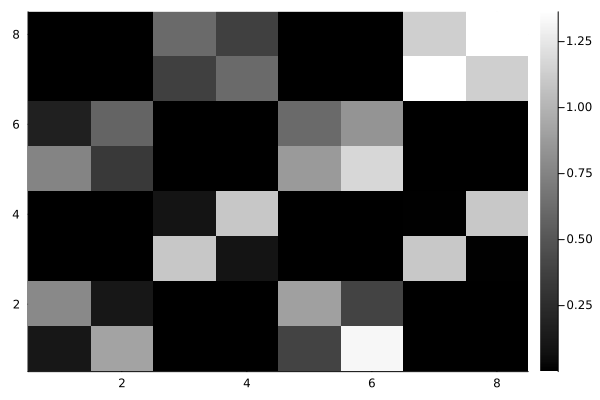

In [31]:
using Plots
heatmap(abs.(vects^2), color = :greys)

**Now we can plot the band structure and DOS**

Symmetry info
Space group # 216     F-43m      F -4 2 3
Point group   -43m
spg 216 F-43m F
7.296 7.296 7.296  |  60.0 60.0 60.0
centering F true
align fermi -0.10712655296178408 -------------------------
no display
grid [16, 16, 16]
dos fermi -0.10620771246645189 xxxxxxxxxxxxx---------------
nspin 1
Projection type: atomic
PROJ
("P", [5, 6, 7, 8], 4)
("Al", [1, 2, 3, 4], 4)
proj_inds [5, 6, 7, 8]
proj_inds [1, 2, 3, 4]
(4096, 8, 2, 1)
Int DOS 7.999997037813593
Int DOS occ 3.999999964331952
Int pDOS occ 1 : 2.7964786418386187
Int pDOS occ 2 : 1.2035213224933339
Int pDOS all 1 : 3.999999090482648
Int pDOS all 2 : 3.999997947330942
DOS flit range (-14.523154815030251, 10.86007830775062)


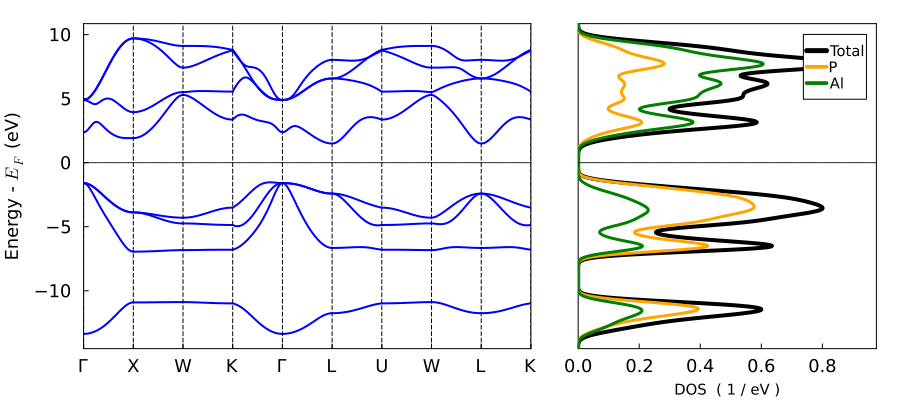

In [ ]:
tbc_new, plot_object = plot_bandstr_dos(tbc);

**Calculate energy, force, and stress**

In [ ]:
energy, force, stress, tbc = scf_energy_force_stress(tbc);


Calculate Force, Stress (no scf)
DO CLASSICAL true

START SCF ----------------
SCF CALC 0001 energy  -10.90639632    
SCF CALC 0002 energy  -10.90639019  en_diff:   6.130664E-06  dq_diff:   8.202471E-04   mix: 1.000000E+00 

YES convergence in 2 iters, energy -10.906390188801593 eV  
END SCF ------------------

ΔQ = [-0.82, 0.82]

(Pre-)Calculate Jacobian of TB object
  0.024041 seconds (27.15 k allocations: 27.926 MiB)
Calculate Force / Stress
  0.020700 seconds (259.13 k allocations: 21.244 MiB)
  0.017272 seconds (244.97 k allocations: 14.920 MiB)
  0.011013 seconds (155.76 k allocations: 9.487 MiB)
done
----

Formation energy: -0.717 eV/atom

Lattice Vectors                       | Stress
-----------------------------------------------------------------------
A1=     +0.00000  +2.72157  +2.72157  |  +0.02835  +0.00000  +0.00000
A2=     +2.72157  +0.00000  +2.72157  |  +0.00000  +0.02835  +0.00000
A3=     +2.72157  +2.72157  +0.00000  |  +0.00000  +0.00000  +0.02835

Crystal coords

**We can also do a relaxation of the forces and stresses. We will expand the starting crystal by 10% so there is something to relax.**

In [ ]:
cfinal, tbc, energy, force, stress = relax_structure(c * 1.1 );

  0.008176 seconds (43.98 k allocations: 1.541 MiB)
DO CLASSICAL true

START SCF ----------------
SCF CALC 0001 energy  -10.41948519    
SCF CALC 0002 energy  -10.41873597  en_diff:   7.492193E-04  dq_diff:   1.727807E+00   mix: 1.000000E+00 
SCF CALC 0003 energy  -10.41718817  en_diff:   1.547804E-03  dq_diff:   1.642638E+00   mix: 1.000000E+00 
SCF CALC 0004 energy  -10.22462507  en_diff:   1.925631E-01  dq_diff:   9.992915E-03   mix: 1.000000E+00 
SCF CALC 0005 energy  -10.22319628  en_diff:   1.428792E-03  dq_diff:   3.282020E-03   mix: 1.000000E+00 
SCF CALC 0006 energy  -10.22249488  en_diff:   7.013986E-04  dq_diff:   3.467126E-06   mix: 1.000000E+00 
SCF CALC 0007 energy  -10.22249587  en_diff:   9.953398E-07  dq_diff:   1.191102E-06   mix: 1.000000E+00 

YES convergence in 7 iters, energy -10.222495871893637 eV  
END SCF ------------------

ΔQ = [-0.74, 0.74]

starting vec 
[0.0, 0.0, 0.0, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Conj Grad START
  0.007301 seconds (43

**This static image shows a direct comparison of the band structure to DFT. We cannot reproduce it as part of this exercise because colab doesn't have Quantum Espresso installed.** The command required is

```
kpts, names, c_std = ThreeBodyTB.Symmetry.get_kpath_sym(c);
ThreeBodyTB.BandStruct.run_dft_compare(tbc, nprocs=2, kpath=kpts, names=names);
```



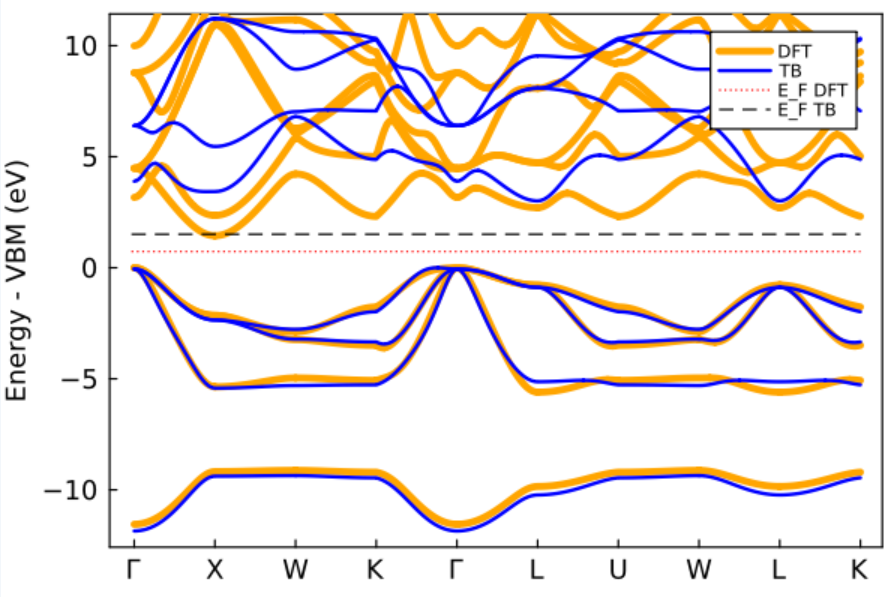

**We can calculate the energy of the 2x2x2 cell and compare to our primitive calculation**

In [ ]:
energy222, tbc222, flag222 = scf_energy(c222);
println()
println("Energy ratio ", energy222/energy)



  0.065525 seconds (526.02 k allocations: 18.213 MiB)
DO CLASSICAL true

START SCF ----------------
SCF CALC 0001 energy  -88.18921920    
SCF CALC 0002 energy  -88.18622991  en_diff:   2.989287E-03  dq_diff:   1.395274E+01   mix: 1.000000E+00 
SCF CALC 0003 energy  -88.18001109  en_diff:   6.218827E-03  dq_diff:   1.332511E+01   mix: 1.000000E+00 
SCF CALC 0004 energy  -87.24710123  en_diff:   9.329099E-01  dq_diff:   2.169395E-02   mix: 1.000000E+00 
SCF CALC 0005 energy  -87.24521672  en_diff:   1.884514E-03  dq_diff:   6.929644E-03   mix: 1.000000E+00 

YES convergence in 5 iters, energy -87.24521671639607 eV  
END SCF ------------------

ΔQ = [-0.82, 0.82, -0.82, 0.82, -0.82, 0.82, -0.82, 0.82, -0.82, 0.82, -0.82, 0.82, -0.82, 0.82, -0.82, 0.82]

scf_energy success, done

Formation energy: -0.717 eV/atom


Energy ratio 7.999531578591496


**Feel free to try your own structures. Also note, we can load crystal structures from POSCAR strings or POSCAR or QE filenames**

In [ ]:
POSCAR = """title kfg
1.0000000
0.0  5.0  5.0
5.0  0.0  5.0
5.0  5.0  0.0
Na Cl
1 1
Direct
0.0  0.0 0.0
0.5  0.5 0.5"""

ct = makecrys(POSCAR)

newlines found, interpret as string containing file instead of filename


Units: Å

A1=     0.00000  5.00000  5.00000
A2=     5.00000  0.00000  5.00000
A3=     5.00000  5.00000  0.00000

Na   0.00000  0.00000  0.00000
Cl   0.50000  0.50000  0.50000
